In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy import constants
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from typing import Union
import time

sqrt = np.sqrt
pi = np.pi
tau = 2*pi

In [2]:
kb = constants.Boltzmann
hb = constants.hbar
mcs = 132.90545*constants.atomic_mass
c=constants.c
eps = constants.epsilon_0
g = 9.81 #m/s**2
gu = g*1e-6  #um/us**2

In [6]:
omega0 = tau*53.3e3 # Hz
w0 = 2.6e-6 # m
T = tau/omega0

def EoM(y,freq,waist):
    x = y[0]
    return [y[1],-x*freq**2*np.exp(-2*x**2/waist**2)]

tspan = [0,1e-3]
y0 = [w0/2,0]
teval = np.arange(tspan[0],tspan[1],T/30)
ys = solve_ivp(lambda t,y: EoM(y,omega0,w0), tspan, y0, t_eval=teval,method="Radau")

In [7]:
ts = ys["t"]
xs = ys["y"][0]
vs = ys["y"][1]
fig,ax=plt.subplots(1,1)
ax.plot(ts,xs/max(xs),label="x")
ax.plot(ts,vs/max(vs),label="v")
ax.legend()
fig.show()

<IPython.core.display.Javascript object>

In [8]:
U0 = 1/4*mcs*omega0**2*w0**2

E = 1/2*mcs*vs**2-U0*np.exp(-2*xs**2/w0**2)
#E = 1/2*mcs*vs**2+1/2*mcs*omega0**2*xs**2
fig,ax = plt.subplots(1,1)
ax.plot(ts,(E-E[0])/E[0])
ax.set_xlabel("Time")
ax.set_ylabel("Atom Energy (uK)")
fig.show()

<IPython.core.display.Javascript object>

In [9]:
1e3*U0/kb

3.0297686285449745

In [10]:
# for 2.8um wide 938nm trap, power that produces a 1mK trap depth
P1mK = 18.9105# mW
wref = 2.8 # um
Ut = lambda P, w: P/P1mK * (wref/w)**2 # mK

# from polarizability
def trap_depth(alpha:float, P:float, w:float):
    """
    computes trap depth in mK, assuming gaussian beam
    Args:
        alpha : dynamic polarizability at trap wavelength, in SI units (MHz/(V/m)^2)
        P : total power in beam (mW)
        w : beam waist (um)
    """
    return (-alpha/(pi*c*eps)*P*1e-3/(w*1e-6)**2)/kb*1e3  # trap depth in mK

#alpha0 at 938nm
alpha_FORT_CGS = -429 # angstrom^3
alpha_FORT_SI = alpha_FORT_CGS*1e-30*4*pi*eps

U = lambda P,w: trap_depth(alpha_FORT_SI,P,w)
zr_gauss = lambda w, l: pi*w**2/l
# zr_exp = 16  #um

In [11]:
Pt = 18.5e-3 # W
omega_t = tau*25.56e3 # Hz
#omega_a = tau*9e3/0.94 #Hz

w0t = sqrt( sqrt(Pt)/omega_t * sqrt(-4*alpha_FORT_SI/(mcs*pi*c*eps)) )
#w0a = ( sqrt(Pt)/omega_a * 938e-9/pi * sqrt(-2*alpha_FORT_SI/(mcs*pi*c*eps)) )**(1/3)
#zr = sqrt(Pt)/w0t/omega_a*sqrt(-2*alpha_FORT_SI/(mcs*pi*c*eps))
zr = pi*w0t**2/938e-9

In [12]:
#trap frequencies
omega_t = lambda P, w: sqrt(4*kb*Ut(P,w)*1e-3/(mcs*(w*1e-6)**2))*1e-3  # transverse frequency, kHz
omega_a = lambda P, w, zr: sqrt(2*kb*Ut(P,w)*1e-3/(mcs*(zr*1e-6)**2))*1e-3  # axial frequency, kHz

# compute std from Boltzmann dist
sigma_x_boltz = lambda T,o: sqrt(kb*T*1e-6/(mcs*(o*1e3)**2))*1e6  # report T in uK and o in kHz. Returned in um
sigma_v_boltz = lambda T: sqrt(kb*T*1e-6/mcs)  # report T in uK and o in kHz. Returned in m/s

beam_u = lambda w, zr, x, y, z: np.exp(-2*(x**2+y**2+z**2)/w**2/(1+(z/zr)**2))/(1+(z/zr)**2)

In [13]:
print(w0t*1e6,zr*1e6)

2.937066259620904 28.89179487256129


In [14]:
trap_depth(alpha_FORT_SI,21,2.94)

1.0072515208814987

In [16]:
omega_t(55,2.5)

382.1937193506309

$\sigma_x = \sqrt{\frac{k_bT}{m\omega^2}}$
$\sigma_v = \sqrt{\frac{k_bT}{m}}$


In [17]:
print(Ut(18.9105,2.8))
print(U(18.9105,2.8))

1.0
1.000000568995553


In [18]:
# trap properties
l = 938e-3  # nm
Pts = np.array([27,55,85])  # mW
Pt = Pts[1]
w0 = 2.68  # um
zr_exp = 14  # um

# atom properties
Temp = 100 # uK

In [19]:
ot = omega_t(Pt,w0)
oa = omega_a(Pt,w0,zr_exp)

std_t = sigma_x_boltz(Temp,ot)
std_a = sigma_x_boltz(Temp,oa)
std_v = sigma_v_boltz(Temp)

In [20]:
oa/tau

7.164829621371578

In [21]:
#compute trap parameters
ot = omega_t(Pt,w0)
oa = omega_a(Pt,w0,zr_exp)

n = 1000

T_list = np.arange(10,300,20)
t_list = np.linspace(0,100,500)
retention = np.zeros((len(T_list),len(t_list)),dtype=float)
for j, T in enumerate(T_list):
    std_t = sigma_x_boltz(T,ot)
    std_a = sigma_x_boltz(T,oa)
    std_v = sigma_v_boltz(T)

    # establish initial conditions
    xi = np.random.normal(scale=std_t,size=n)
    yi = np.random.normal(scale=std_t,size=n)
    zi = np.random.normal(scale=std_a,size=n)

    vxi = np.random.normal(scale=std_v,size=n)
    vyi = np.random.normal(scale=std_v,size=n)
    vzi = np.random.normal(scale=std_v,size=n)
    
    
    # establish initial conditions
    Uk = 1/2*mcs*(vxi**2+vyi**2+vzi**2)/kb*1e3
    Upi = -Ut(Pt,w0)*beam_u(w0,zr_exp,xi,yi,zi)

    bad_inds = np.argwhere(Uk+Upi>0)
    Ui = Upi+Uk
    Ui[bad_inds] = np.NaN

    for i, dt in enumerate(t_list):
    #    dt = 10 #us
        xf = xi+vxi*dt  #um
        yf = yi+vyi*dt-0.5*gu*dt**2  #um
        zf = zi+vzi*dt  #um
        Upf = -Ut(Pt,w0)*beam_u(w0,zr_exp,xf,yf,zf)

        Uf = Upf+Uk
        Uf[bad_inds] = np.NaN

        keep = Uf<0
        retention[j,i] = sum(keep)/(n-len(bad_inds))
    print(bad_inds.shape)

dret = retention*(1-retention)

(0, 1)
(0, 1)
(5, 1)
(17, 1)
(36, 1)
(70, 1)
(112, 1)
(138, 1)
(183, 1)
(214, 1)
(229, 1)
(269, 1)
(325, 1)
(324, 1)
(352, 1)


In [10]:
dret = dret/sqrt(n)

In [11]:
fig,ax = plt.subplots(1,1)
for i,T in enumerate(T_list):
    ret = retention[i]
    ax.errorbar(t_list,ret,dret[i],label=f"|T| = {T}uK")
ax.legend()
fig.show()

<IPython.core.display.Javascript object>

In [174]:
fig,ax = plt.subplots(1,1)
for i,T in enumerate(T_list):
    ax.errorbar(t_list,(ret_f[i]-retention[i])/ret_f[i],dret_f[i]-dret[i],label=f"|T| = {T}uK")
ax.legend()
fig.show()

<IPython.core.display.Javascript object>

In [14]:
def drop_recapture_MC(
    t: Union[float,np.ndarray],
    T: float,
    P: float,
    w: float,
    zr: float=None,
    m:float=mcs,
    l:float=938e-3,
    n:int=1000,
):
    """
    Monte-Carlo simulation determines the probability of re-capturing an atom after drop times of length t.
    Args:
        t : length of the drop phase before the re-capture
        T : atom temperature (uK)
        P : power in the dipole trap (mW)
        w : waist of dipole trap (um)
        zr : optional, measured Rayleigh range of trap, if not specified it's computed based on w and l (um)
        m : optional, mass of trapped atom, default is mass of cesium (kg)
        l : optional, trap wavelegth, default is 938nm (um)
        n : optional, number of atoms to simulate
    Returns:
        retention, retention_std: retention probability and statistical uncertainty in that probability at each time-step
    """
    
    if zr is None:
        zr = pi*w0**2/l
    freq_t = omega_t(Pt,w0)
    freq_a = omega_a(Pt,w0,zr)
    
    std_t = sigma_x_boltz(T,freq_t)
    std_a = sigma_x_boltz(T,freq_a)
    std_v = sigma_v_boltz(T)

    # establish initial conditions
    xi = np.random.normal(scale=std_t,size=n)
    yi = np.random.normal(scale=std_t,size=n)
    zi = np.random.normal(scale=std_a,size=n)

    vxi = np.random.normal(scale=std_v,size=n)
    vyi = np.random.normal(scale=std_v,size=n)
    vzi = np.random.normal(scale=std_v,size=n)
    
    Uk = 1/2*m*(vxi**2+vyi**2+vzi**2)/kb*1e3
    Upi = -Ut(P,w)*beam_u(w,zr,xi,yi,zi)

    # remove atoms that would not be trapped initially
    bad_inds = np.argwhere(Uk+Upi>0)
    Ui = Upi+Uk
    Ui[bad_inds] = np.NaN
    
    try:
        retention = np.zeros(len(t))
        ret_std = np.zeros(retention.shape)
        for i, dt in enumerate(t):
            #    dt = 10 #us
            xf = xi+vxi*dt  #um
            yf = yi+vyi*dt-0.5*gu*dt**2  #um
            zf = zi+vzi*dt  #um
            Upf = -Ut(Pt,w0)*beam_u(w0,zr_exp,xf,yf,zf)

            Uf = Upf+Uk
            Uf[bad_inds] = np.NaN

            keep = Uf<0
            retention[i] = sum(keep)/(n-len(bad_inds))
            ret_std[i] = retention[i]*(1-retention[i])/sqrt(n-len(bad_inds))
    except TypeError:
        retention = 0
        xf = xi+vxi*dt  #um
        yf = yi+vyi*dt-0.5*gu*dt**2  #um
        zf = zi+vzi*dt  #um
        Upf = -Ut(Pt,w0)*beam_u(w0,zr_exp,xf,yf,zf)

        Uf = Upf+Uk
        Uf[bad_inds] = np.NaN

        keep = Uf<0
        retention = sum(keep)/(n-len(bad_inds))
        ret_std = retention*(1-retention)/sqrt(n-len(bad_inds))
        
    return retention, ret_std

In [15]:
#compute trap parameters
ot = omega_t(Pt,w0)
oa = omega_a(Pt,w0,zr_exp)

n = 1000

T_list = np.arange(10,300,20)
t_list = np.linspace(0,100,500)
retention = np.zeros((len(T_list),len(t_list)),dtype=float)
ret_std = np.zeros(retention.shape)

for i, T in enumerate(T_list):
    ts = time.time()
    retention[i], ret_std[i] = drop_recapture_MC(t_list, T, Pt, w0, zr_exp, mcs, 938e-3, n=1000)
    te = time.time()
    print(f"computed MC in {(te-ts)*1e3}ms")

computed MC in 642.2834396362305ms
computed MC in 639.2917633056641ms
computed MC in 634.3050003051758ms
computed MC in 636.3310813903809ms
computed MC in 640.2580738067627ms
computed MC in 637.2971534729004ms
computed MC in 638.2937431335449ms
computed MC in 647.3052501678467ms
computed MC in 635.3030204772949ms
computed MC in 638.2741928100586ms
computed MC in 641.2496566772461ms
computed MC in 645.2755928039551ms
computed MC in 648.2675075531006ms
computed MC in 638.2942199707031ms
computed MC in 634.2647075653076ms


In [16]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
for i,T in enumerate(T_list):
    ax.errorbar(t_list,retention[i],ret_std[i],label=f"|T| = {T}uK")
ax.set_yscale("log")
ax.legend(loc='center right',bbox_to_anchor=(1.4,0.5),ncol=1)
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>

In [30]:
T = np.random.normal(100,30)
tl = np.linspace(0,100,21)
ret_tst,dr = drop_recapture_MC(tl,T,Pt,w0,zr_exp,n=150)

<IPython.core.display.Javascript object>


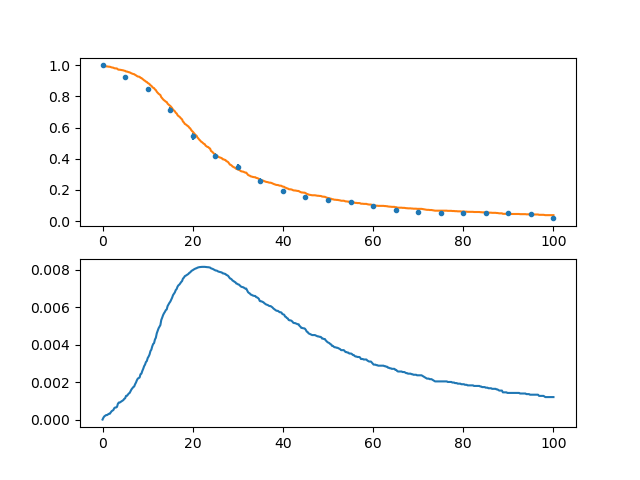

In [31]:
fig,axar =plt.subplots(2,1)
ax=axar[0]
ax.errorbar(tl,ret_tst,dr,fmt=".",label="experiment")
retention,dret = drop_recapture_MC(t_list,T,Pt,w0,zr_exp,n=1000)
ax.plot(t_list,retention,label="MC")

ax=axar[1]
ax.plot(t_list,dret)
fig.show()

In [32]:
def MC_res(
    t_samples: np.ndarray,
    retention: np.ndarray,
    retention_errb: np.ndarray,
    T: float,
    P: float,
    w: float,
    zr: float=None
):
    """
    Computes residuals of provided retention data with respect to monte-carlo simulation of trapped atom at finite temperature
    Args:
        t_samples: drop times used experimentally (us)
        retention: experimental retention values
        retention_errb: statistical uncertainty in experimental retention values
        T: atom temperature (uK)
        P: trap power (mW)
        w: trap waist (um)
        zr: optional, trap Rayleigh range. If not provided, computed form trap parameters (assumed 938nm trap) (um)
    Returns:
        residual, residuals_errb: computed residuals and uncertainty in those residuals (MC and experimental uncertainty added
            in quadrature)
    """
    tl = np.linspace(0,max(t_samples)*1.3,400)
    retMC, dretMC = drop_recapture_MC(tl,T,P,w,zr)
    
    rate=4
    ys = np.zeros((rate,len(t_samples)))
    dys = np.zeros(ys.shape)
    # interpolate MC but smooth it out
    for o in range(rate):
        tr=tl[o::rate]
        yr=retMC[o::rate]
        dy=dretMC[o::rate]

        tr[0] = 0
        yr[0] = 1
        dy[0] = 0

        fun = interp1d(tr,yr,kind="quadratic")
        dfun = interp1d(tr,dy,kind="quadratic")

        ys[o]=fun(t_samples)
        dys[o]=dfun(t_samples)
    
    yavg = ys.mean(0)
    dyavg = dys.mean(0)
    
    residuals = yavg-retention
    residuals_errb = sqrt(dyavg**2+retention_errb**2)
    
    return residuals, residuals_errb

In [33]:
ts = time.time()
residuals, residuals_errb = MC_res(tl,ret_tst,dr,T,Pt,w0,zr_exp)
tf = time.time()
print(sqrt(sum(residuals**2))/len(residuals))
print(f"execution time = {(tf-ts)*1e3:.0f}ms")
fig,ax = plt.subplots(1,1)
ax.errorbar(tl,residuals,residuals_errb)
ax.axhline(0,ls=":")
ax.set_title(f"residual RMS = {sqrt(sum(residuals**2))/len(residuals):.2e}")
fig.show()

0.005700596502081734
execution time = 558ms


<IPython.core.display.Javascript object>

In [47]:
temps = T*(1+np.linspace(-.4,.4,31))
res_rms = np.zeros(temps.shape)
res_rms_std = np.zeros(temps.shape)
for i,temp in enumerate(temps):
    residuals, residuals_errb = MC_res(tl,ret_tst,dr,temp,Pt,w0,zr_exp)
    res_rms[i] = sqrt(sum(residuals**2))/len(residuals)
    nres = np.copy(residuals)
    nres[np.where(nres==0)] = np.NaN
    q_res = residuals_errb**2/residuals**2
    q_res = np.nan_to_num(q_res,True)
    res_rms_std[i] = res_rms[i]*sqrt(sum(q_res))
fig,ax = plt.subplots(1,1)
ax.errorbar(temps,res_rms,res_rms_std,fmt=".")
ax.axvline(T,ls=":")
fig.show()

<ipython-input-47-45e808522c49>:9: RuntimeWarning: invalid value encountered in true_divide
  q_res = residuals_errb**2/residuals**2


<IPython.core.display.Javascript object>

In [48]:
res_rms_std

array([0.01533868, 0.01948425, 0.01325535, 0.01584541, 0.01408109,
       0.02409129, 0.01307137, 0.03012505, 0.02816361, 0.01897095,
       0.12514426, 0.07013011, 0.04212939, 0.22305617, 0.0223455 ,
       0.03346243, 0.04895682, 0.12360316, 0.03860872, 0.04749271,
       0.06556562, 0.06231661, 0.12283582, 0.13275768, 0.02428845,
       0.02349492, 0.04700117, 0.51687764, 0.01795858, 0.0144885 ,
       0.01721239])

In [166]:
ret_f = retention
dret_f = ret_std

In [ ]:
def drop_recapture_MC(
    t: Union[float,np.ndarray],
    T: float,
    P: float,
    w: float,
    zr: float=None,
    m:float=mcs,
    l:float=938e-3,
    n:int=1000,
):

In [24]:
def evolve(xi,vi,dt,pot=None,g=False,omega=0):
    """
    Perform time-evolution on an array of initial positions, given a potential
    args:
        xi: ndarray,float: initial positions
        vi: ndarray,float: initial velocities
        dt: size of timestep
        pot: potential underwhich particles evolve.
    """
    if pot is None:
        return xi+vi*dt-g*0.5*gu*dt**2,vi-g*gu*dt
    elif pot == "SHO":
        if omega==0:
            raise RuntimeError("Give good SHO frequency")
        rg=  -vi/xi/(omega*1e-3)
        A = xi*np.sqrt(1+rg**2)
        phi = np.arctan(rg)
        xf = A*np.cos(omega*1e-3*dt+phi)
        vf = -A*omega*1e-3*np.sin(omega*1e-3*dt+phi)
        return xf,vf


In [22]:
# trap properties
l = 938e-3  # nm
Pts = np.array([27,55,85])  # mW
Pt = Pts[1]
w0 = 2.54  # um
zr_exp = 14  # um

# atom properties
Temp = 10 # uK

# trap frequency
ot = omega_t(Pt,w0)
oa = omega_a(Pt,w0,zr_exp)
print(f"$\omega_t = 2\pi\\times{ot/tau}kHz$")
print(f"$\omega_a = 2\pi\\times{oa/tau}kHz$")

n=10000
# boltzmann stds
std_t = sigma_x_boltz(Temp,ot)
std_a = sigma_x_boltz(Temp,oa)
std_v = sigma_v_boltz(Temp)

# initial position-velocity
xi = np.random.normal(scale=std_t,size=n)
yi = np.random.normal(scale=std_t,size=n)
zi = np.random.normal(scale=std_a,size=n)

x0 = np.array([xi,yi,zi])

vxi = np.random.normal(scale=std_v,size=n)
vyi = np.random.normal(scale=std_v,size=n)
vzi = np.random.normal(scale=std_v,size=n)

v0 = np.array([vxi,vyi,vzi])

total_time = 10 #us
time_steps = 10
dt = total_time/time_steps

$\omega_t = 2\pi\times58.92726189368672kHz$
$\omega_a = 2\pi\times7.559741490266074kHz$


<IPython.core.display.Javascript object>


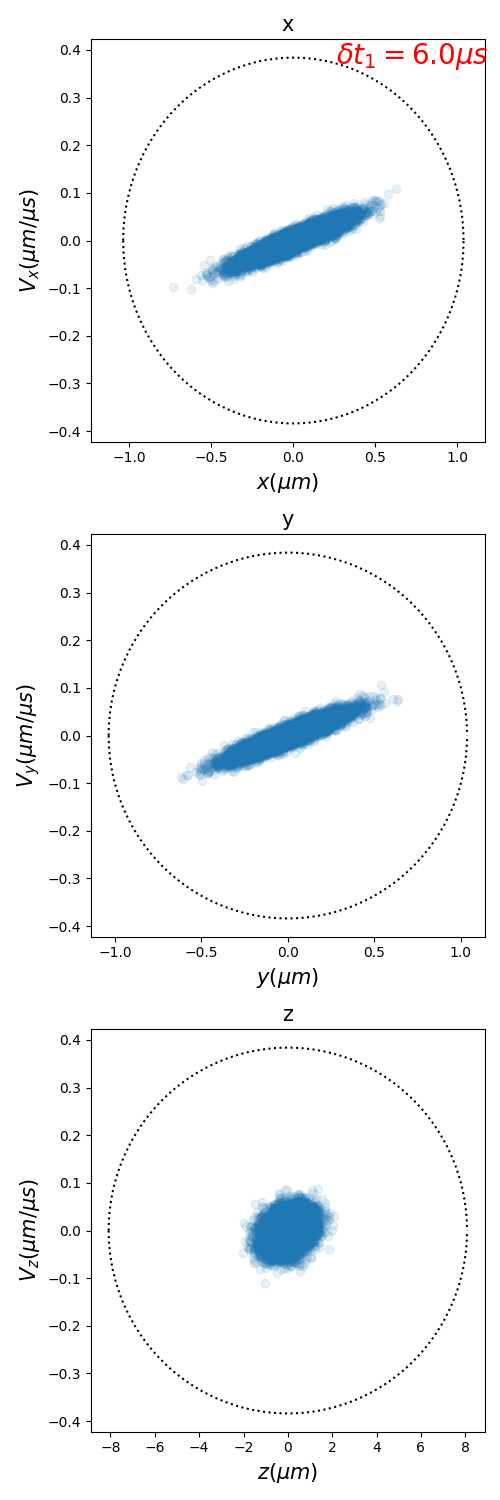

MovieWriter imagemagick unavailable; using Pillow instead.


In [25]:
total_time = 10 #us
time_steps = 10
dt = total_time/time_steps

# free expansion
xn = xi
yn = yi
zn = zi

vi = v0
xs = np.zeros((3,time_steps+1,len(xn)),dtype=float)
xs[:,0,:] = x0

#fig,axar=plt.subplots(time_steps,1,figsize=(5,5*time_steps))
for i in range(time_steps):
    for j,axis in enumerate("xyz"):
        xs[j,i+1,:] = evolve(xs[j,i,:],vi[j,:],dt)[0]

def init(scat):
    scat.set_offset([],[])
    return scat,

def update(scats,title,i):
    for j,scat in enumerate(scats):
        scat.set_offsets(np.array([xs[j,i,:],vi[j,:]]).T)
    tms = f"$\delta t_1={i*dt}\mu s$"
    title.set_text(tms)
    return scats, title

fig,axar = plt.subplots(3,1,figsize=(5,15))

scats = [axar[j].scatter(xs[j,-1,:],vi[-1],alpha=0.1) for j in range(3)]
tms = f"$\delta t_1={0}\mu s$"

mx = axar[0].get_xlim()[1]
my =axar[0].get_ylim()[1]
title = axar[0].text(0.26,0.37,tms,c="r",fontsize=20)
for j,axis in enumerate("xyz"):
    axar[j].set_title(axis)
    axar[j].set_xlabel(f"${axis} (\mu m$)")
    axar[j].set_ylabel(f"$V_{{{axis}}} (\mu m /\mu s$)")
    

U = lambda P,w: trap_depth(alpha_FORT_SI,P,w)
Ud = U(Pt,w0)*kb*1e-3
equip = True
x_mt = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(ot*1e3)
x_ma = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(oa*1e3)
xtlin = np.linspace(-x_mt,x_mt,1000)*1e6
xalin = np.linspace(-x_ma,x_ma,1000)*1e6
for j, ax in enumerate(axar):
    if j<2:
        ax.plot(xtlin,sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,t}$")
        ax.plot(xtlin,-sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    else:
        ax.plot(xalin,sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,a}$")
        ax.plot(xalin,-sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    for txt in [ax.xaxis.label,ax.yaxis.label,ax.title]:
        txt.set_fontsize(15)

ani = animation.FuncAnimation(fig,lambda i: update(scats,title,i),interval=100,frames=time_steps,repeat=True,repeat_delay=200)
fig.tight_layout()
fig.show()
ani.save("free_expansion.gif",writer="imagemagick")

<IPython.core.display.Javascript object>


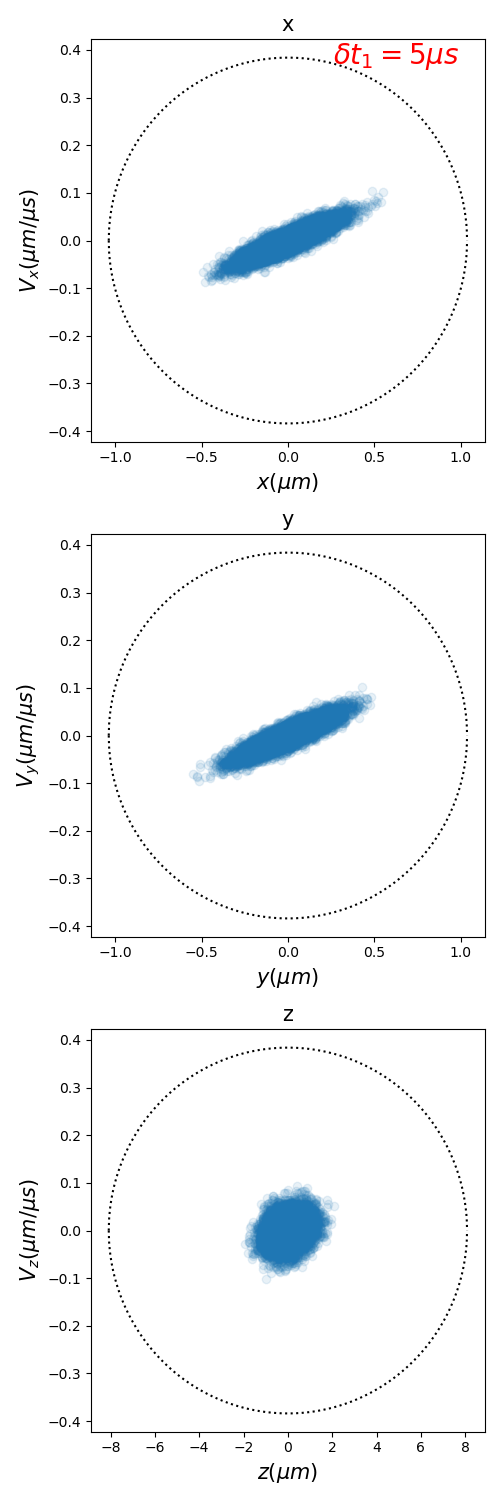

In [17]:
total_time = 10 #us
time_steps = 10
dt = total_time/time_steps

# free expansion
xn = xi
yn = yi
zn = zi

vi = v0
xs = np.zeros((3,time_steps+1,len(xn)),dtype=float)
xs[:,0,:] = x0


fig,axar = plt.subplots(3,1,figsize=(5,15))

x5,v5 = evolve(x0,v0,5)
scats = [axar[j].scatter(x5[j],v5[j],alpha=0.1) for j in range(3)]
tms = f"$\delta t_1={5}\mu s$"

mx = axar[0].get_xlim()[1]
my =axar[0].get_ylim()[1]
title = axar[0].text(0.26,0.37,tms,c="r",fontsize=20)
for j,axis in enumerate("xyz"):
    axar[j].set_title(axis)
    axar[j].set_xlabel(f"${axis} (\mu m$)")
    axar[j].set_ylabel(f"$V_{{{axis}}} (\mu m /\mu s$)")
    

U = lambda P,w: trap_depth(alpha_FORT_SI,P,w)
Ud = U(Pt,w0)*kb*1e-3
equip = True
x_mt = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(ot*1e3)
x_ma = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(oa*1e3)
xtlin = np.linspace(-x_mt,x_mt,1000)*1e6
xalin = np.linspace(-x_ma,x_ma,1000)*1e6
for j, ax in enumerate(axar):
    if j<2:
        ax.plot(xtlin,sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,t}$")
        ax.plot(xtlin,-sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    else:
        ax.plot(xalin,sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,a}$")
        ax.plot(xalin,-sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    for txt in [ax.xaxis.label,ax.yaxis.label,ax.title]:
        txt.set_fontsize(15)
fig.tight_layout()
fig.show()
fig.savefig("free_expansion5.png")

In [19]:
total_time = tau/(ot*1e-3) #us
time_steps = 20
dt = total_time/time_steps

# free expansion


xs = np.zeros((3,time_steps+1,len(xn)),dtype=float)
vs = np.zeros(xs.shape,dtype=float)
xs[:,0,:],vs[:,0,:] = evolve(x0,v0,5)

#fig,axar=plt.subplots(time_steps,1,figsize=(5,5*time_steps))
for i in range(time_steps):
    for j,axis in enumerate("xyz"):
        if j<2:
            omega=ot
        else:
            omega=oa
        xs[j,i+1,:],vs[j,i+1,:] = evolve(xs[j,i,:],vs[j,i,:],dt,"SHO",omega=omega)

def init(scat):
    scat.set_offset([],[])
    return scat,

def update(scats,title,i):
    for j,scat in enumerate(scats):
        scat.set_offsets(np.array([xs[j,i,:],vs[j,i,:]]).T)
    tms = f"$\Delta t={i*dt/total_time:.2f}$ $2\pi/\omega_t$"
    tms = f"$\omega_t \Delta t= 2\pi{i*dt/total_time:.2f}$"
    title.set_text(tms)
    return scats, title

fig,axar = plt.subplots(3,1,figsize=(5,15))

scats = [axar[j].scatter(xs[j,-1,:],vs[j,-1,:],alpha=0.1) for j in range(3)]
tms = f"$\omega_t \Delta t= 2\pi{0:.2f}$"

mx = axar[0].get_xlim()[1]
my =axar[0].get_ylim()[1]
title = axar[0].text(0.20,0.45,tms,c="r",fontsize=20)
xlims = [(0,0)]*3
ylims = [(0,0)]*3
for j,axis in enumerate("xyz"):
    axar[j].set_title(axis)
    axar[j].set_xlabel(f"${axis} (\mu m$)")
    axar[j].set_ylabel(f"$V_{{{axis}}} (\mu m /\mu s$)")
    

U = lambda P,w: trap_depth(alpha_FORT_SI,P,w)
Ud = U(Pt,w0)*kb*1e-3
equip = True
x_mt = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(ot*1e3)
x_ma = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(oa*1e3)
xtlin = np.linspace(-x_mt,x_mt,1000)*1e6
xalin = np.linspace(-x_ma,x_ma,1000)*1e6
for j, ax in enumerate(axar):
    if j<2:
        ax.plot(xtlin,sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,t}$")
        ax.plot(xtlin,-sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    else:
        ax.plot(xalin,sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,a}$")
        ax.plot(xalin,-sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    for txt in [ax.xaxis.label,ax.yaxis.label,ax.title]:
        txt.set_fontsize(15)
    xlims[j]=axar[j].get_xlim()
    ylims[j]=axar[j].get_ylim()
ani = animation.FuncAnimation(fig,lambda i: update(scats,title,i),interval=100,frames=time_steps,repeat=True,repeat_delay=200)
fig.tight_layout()
fig.show()
ani.save("oscillations.gif",writer="imagemagick")

<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


In [22]:
total_time = 20 #us
time_steps = 20
dt = total_time/time_steps

# re-expansion


xs = np.zeros((3,time_steps+1,len(xn)),dtype=float)
vs = np.zeros(xs.shape,dtype=float)
xexp,vexp = evolve(x0,v0,5)
for j in range(3):
    if j < 2:
        om = ot
    else:
        om = oa
    pref = (1/16+1/4)*1.015 # max loss
    #pref = 1/16*1.015 # min loss
    xs[j,0,:],vs[j,0,:] = evolve(xexp[j],vexp[j],pref*tau/(ot*1e-3),"SHO",omega=om)

#fig,axar=plt.subplots(time_steps,1,figsize=(5,5*time_steps))
for i in range(time_steps):
    for j,axis in enumerate("xyz"):
        if j<2:
            omega=ot
        else:
            omega=oa
        xs[j,i+1,:],vs[j,i+1,:] = evolve(xs[j,i,:],vs[j,i,:],dt)

def init(scat):
    scat.set_offset([],[])
    return scat,

def update(scats,title,i):
    for j,scat in enumerate(scats):
        scat.set_offsets(np.array([xs[j,i,:],vs[j,i,:]]).T)
    tms = f"$\delta t_2= {i*dt:.0f}\mu s$"
    title.set_text(tms)
    return scats, title

fig,axar = plt.subplots(3,1,figsize=(5,15))

scats = [axar[j].scatter(xs[j,-1,:],vs[j,-1,:],alpha=0.1) for j in range(3)]
tms = f"$\delta t_2= {0:.2f}\mu s$"

mx = axar[0].get_xlim()[1]
my =axar[0].get_ylim()[1]
title = axar[0].text(0.20,0.45,tms,c="r",fontsize=20)
for j,axis in enumerate("xyz"):
    axar[j].set_title(axis)
    axar[j].set_xlabel(f"${axis} (\mu m$)")
    axar[j].set_ylabel(f"$V_{{{axis}}} (\mu m /\mu s$)")
    

U = lambda P,w: trap_depth(alpha_FORT_SI,P,w)
Ud = U(Pt,w0)*kb*1e-3
equip = True
x_mt = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(ot*1e3)
x_ma = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(oa*1e3)
xtlin = np.linspace(-x_mt,x_mt,1000)*1e6
xalin = np.linspace(-x_ma,x_ma,1000)*1e6
for j, ax in enumerate(axar):
    if j<2:
        ax.plot(xtlin,sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,t}$")
        ax.plot(xtlin,-sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    else:
        ax.plot(xalin,sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,a}$")
        ax.plot(xalin,-sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    ax.set_xlim(xlims[j])
    ax.set_ylim(ylims[j])
    for txt in [ax.xaxis.label,ax.yaxis.label,ax.title]:
        txt.set_fontsize(15)

ani = animation.FuncAnimation(fig,lambda i: update(scats,title,i),interval=100,frames=time_steps,repeat=True,repeat_delay=200)
fig.tight_layout()
fig.show()
ani.save("re-expansion2.gif",writer="imagemagick")

<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


<IPython.core.display.Javascript object>


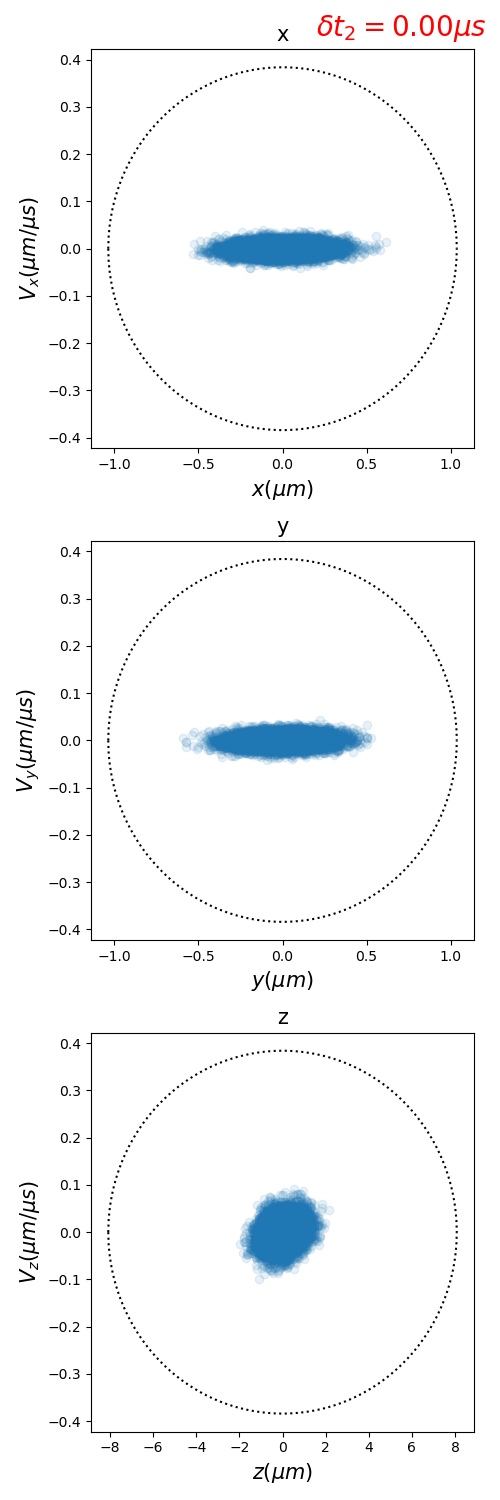

In [24]:
total_time = 20 #us
time_steps = 20
dt = total_time/time_steps

# re-expansion


xs = np.zeros((3,time_steps+1,len(xn)),dtype=float)
vs = np.zeros(xs.shape,dtype=float)
xexp,vexp = evolve(x0,v0,5)
for j in range(3):
    if j < 2:
        om = ot
    else:
        om = oa
    #pref = (1/16+1/4)*1.015 # max loss
    pref = 1/16*1.015 # min loss
    xs[j,0,:],vs[j,0,:] = evolve(xexp[j],vexp[j],pref*tau/(ot*1e-3),"SHO",omega=om)

#fig,axar=plt.subplots(time_steps,1,figsize=(5,5*time_steps))
fig,axar = plt.subplots(3,1,figsize=(5,15))

scats = [axar[j].scatter(xs[j,0,:],vs[j,0,:],alpha=0.1) for j in range(3)]
tms = f"$\delta t_2= {0:.2f}\mu s$"

mx = axar[0].get_xlim()[1]
my =axar[0].get_ylim()[1]
title = axar[0].text(0.20,0.45,tms,c="r",fontsize=20)
for j,axis in enumerate("xyz"):
    axar[j].set_title(axis)
    axar[j].set_xlabel(f"${axis} (\mu m$)")
    axar[j].set_ylabel(f"$V_{{{axis}}} (\mu m /\mu s$)")
    

U = lambda P,w: trap_depth(alpha_FORT_SI,P,w)
Ud = U(Pt,w0)*kb*1e-3
equip = True
x_mt = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(ot*1e3)
x_ma = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(oa*1e3)
xtlin = np.linspace(-x_mt,x_mt,1000)*1e6
xalin = np.linspace(-x_ma,x_ma,1000)*1e6
for j, ax in enumerate(axar):
    if j<2:
        ax.plot(xtlin,sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,t}$")
        ax.plot(xtlin,-sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    else:
        ax.plot(xalin,sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,a}$")
        ax.plot(xalin,-sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")
    ax.set_xlim(xlims[j])
    ax.set_ylim(ylims[j])
    for txt in [ax.xaxis.label,ax.yaxis.label,ax.title]:
        txt.set_fontsize(15)

#ani = animation.FuncAnimation(fig,lambda i: update(scats,title,i),interval=100,frames=time_steps,repeat=True,repeat_delay=200)
fig.tight_layout()
fig.show()
fig.savefig("re-expansionpi.png")
#ani.save("re-expansion2.gif",writer="imagemagick")

<IPython.core.display.Javascript object>


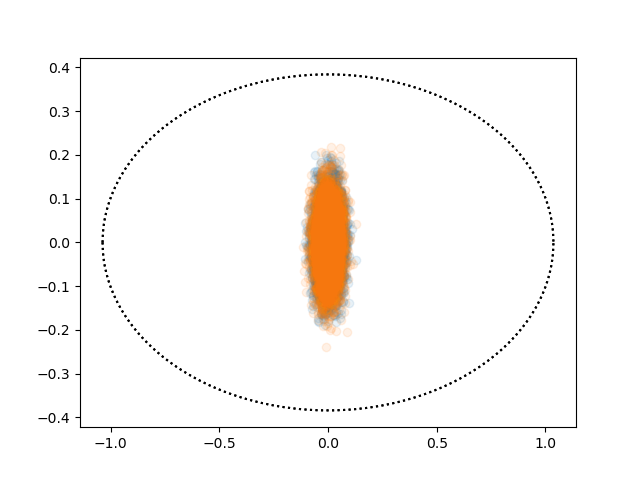

In [80]:
xs = np.zeros((3,time_steps+1,len(xn)),dtype=float)
vs = np.zeros(xs.shape,dtype=float)
xexp,vexp = evolve(x0,v0,5)

for j in range(3):
    if j < 2:
        om = ot
    else:
        om = oa
    xs[j,0,:],vs[j,0,:] = evolve(xexp[j],vexp[j],(1/16+1/4)*1.015*tau/(ot*1e-3),"SHO",omega=om)
    
fig,ax = plt.subplots(1,1)
U = lambda P,w: trap_depth(alpha_FORT_SI,P,w)
Ud = U(Pt,w0)*kb*1e-3
equip = True
x_mt = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(ot*1e3)
x_ma = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(oa*1e3)
xtlin = np.linspace(-x_mt,x_mt,1000)*1e6

for j in range(2):
    ax.scatter(xs[j,0,:],vs[j,0,:],alpha=0.1)
    ax.plot(xtlin,sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,t}$")
    ax.plot(xtlin,-sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")

ax.set_xlim(ax.get_xlim())
fig.show()

<IPython.core.display.Javascript object>


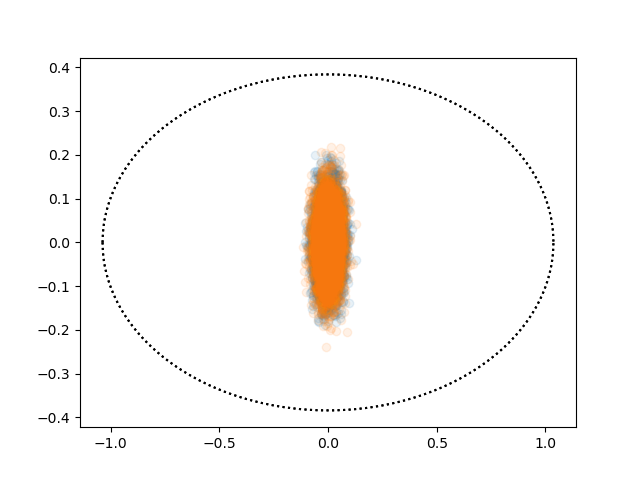

In [80]:
xs = np.zeros((3,time_steps+1,len(xn)),dtype=float)
vs = np.zeros(xs.shape,dtype=float)
xexp,vexp = evolve(x0,v0,5)

for j in range(3):
    if j < 2:
        om = ot
    else:
        om = oa
    xs[j,0,:],vs[j,0,:] = evolve(xexp[j],vexp[j],(1/16+1/4)*1.015*tau/(ot*1e-3),"SHO",omega=om)
    
fig,ax = plt.subplots(1,1)
U = lambda P,w: trap_depth(alpha_FORT_SI,P,w)
Ud = U(Pt,w0)*kb*1e-3
equip = True
x_mt = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(ot*1e3)
x_ma = np.sqrt(2*Ud/3/mcs*(3-2*equip))/(oa*1e3)
xtlin = np.linspace(-x_mt,x_mt,1000)*1e6

for j in range(2):
    ax.scatter(xs[j,0,:],vs[j,0,:],alpha=0.1)
    ax.plot(xtlin,sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k",label="$U_{max,t}$")
    ax.plot(xtlin,-sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*(3-2*equip)),ls=":",c="k")

ax.set_xlim(ax.get_xlim())
fig.show()

In [34]:
ax.get_xlabel()

'$x (\\mu m$)'

In [20]:
x_m = axar[0].get_xlim()[1]
y_m = axar[0].get_xlim()[1]
print(x_m,y_m)

1.1406460480671594 1.1406460480671594


In [54]:
np.abs(xs)

array([[[0.03025655, 0.09408968, 0.10956909, ..., 0.0233547 ,
         0.06501394, 0.02533831],
        [0.01774593, 0.01392018, 0.05880168, ..., 0.02743178,
         0.12217073, 0.02758361],
        [0.00523531, 0.12193003, 0.00803428, ..., 0.07821825,
         0.17932752, 0.08050552],
        ...,
        [0.06982842, 0.76998915, 0.29657014, ..., 0.3829371 ,
         0.52226827, 0.398037  ],
        [0.08233905, 0.877999  , 0.34733754, ..., 0.43372358,
         0.57942506, 0.45095891],
        [0.09484967, 0.98600886, 0.39810494, ..., 0.48451005,
         0.63658185, 0.50388083]],

       [[0.0167404 , 0.03075872, 0.12439331, ..., 0.24021484,
         0.14137045, 0.40673493],
        [0.05134498, 0.00748365, 0.05885529, ..., 0.26635107,
         0.16198203, 0.34791377],
        [0.08594956, 0.01579143, 0.00668273, ..., 0.29248729,
         0.18259362, 0.28909261],
        ...,
        [0.29357704, 0.15544189, 0.39991084, ..., 0.44930465,
         0.30626311, 0.06383433],
        [0.3

<IPython.core.display.Javascript object>


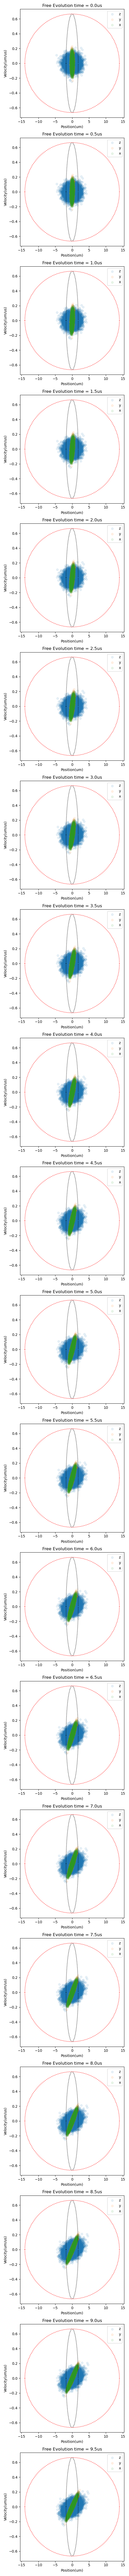

In [103]:
# free expansion
xn = xi
yn = yi
zn = zi

fig,axar=plt.subplots(time_steps,1,figsize=(5,5*time_steps))
for i in range(time_steps):
    ax=axar[i]
    
    ax.scatter(zn,vzi,label="z", alpha=0.1)
    ax.scatter(yn,vyi,label="y", alpha=0.1)
    ax.scatter(xn,vxi,label="x", alpha=0.1)
    ax.set_xlabel("Position(um)")
    ax.set_ylabel("Velocity(um/us)")
    ax.set_title(f"Free Evolution time = {i*dt}us")
    ax.legend()
    
    U = lambda P,w: trap_depth(alpha_FORT_SI,P,w)
    Ud = U(Pt,w0)*kb*1e-3
    x_mt = np.sqrt(2*Ud/3/mcs*3)/(ot*1e3)
    x_ma = np.sqrt(2*Ud/3/mcs*3)/(oa*1e3)
    xtlin = np.linspace(-x_mt,x_mt,1000)*1e6
    xalin = np.linspace(-x_ma,x_ma,1000)*1e6
    ax.plot(xtlin,sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*3),ls=":",c="k",label="$U_{max,t}$")
    ax.plot(xtlin,-sqrt(-(ot*1e3)**2*(xtlin*1e-6)**2+2*Ud/3/mcs*3),ls=":",c="k")
    ax.plot(xalin,sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*3),ls=":",c="r",label="$U_{max,a}$")
    ax.plot(xalin,-sqrt(-(oa*1e3)**2*(xalin*1e-6)**2+2*Ud/3/mcs*3),ls=":",c="r")

    
    xn = evolve(xn,vxi,dt)
    yn = evolve(yn,vyi,dt)
    zn = evolve(zn,vzi,dt)
    
fig.tight_layout()
fig.show()

In [95]:
scat.set_offsets(np.array([xs[0,1,:],vi[0,:]]).T)
fig.show()

In [88]:
fig,ax=plt.subplots()
ax.scatter([xs[:,0,:],vi])
fig.show()

<IPython.core.display.Javascript object>

TypeError: missing a required argument: 'y'

In [72]:
col = ax.scatter([],[])
dir(col)

['_A',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_checker',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiaseds',
 '_axes',
 '_bcast_lwls',
 '_capstyle',
 '_check_update',
 '_clipon',
 '_clippath',
 '_contains',
 '_default_contains',
 '_edge_default',
 '_edgecolors',
 '_facecolors',
 '_factor',
 '_get_clipping_extent_bbox',
 '_gid',
 '_hatch',
 '_hatch_color',
 '_in_layout',
 '_is_filled',
 '_is_stroked',
 '_joinstyle',
 '_label',
 '_linestyles',
 '_linewidths',
 '_mouseover',
 '_offset_position',
 '_offsets',
 '_offsetsNone',
 '_oid',
 '_original_edgecolor',
 '_original_facecolor',
 '_path_effects',
 '_paths',
 '_picker'

In [59]:
xs = np.zeros((3,time_steps+1,len(xn)),dtype=float)
xs[:,0,:] = np.array([xn,yn,zn])
xs

array([[[-0.69763532,  0.50740579,  0.05577395, ...,  0.57416388,
          0.05895036, -0.06417468],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.90146666,  0.3768771 ,  0.27693654, ...,  0.15336884,
          0.21664041,  0.87244611],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [47]:
np.sqrt(2/3/mcs*Ud)

0.38393202987471226

In [71]:
ot = omega_t(Pt,w0)
oa = omega_a(Pt,w0,zr_exp)

std_t = sigma_x_boltz(Temp,ot)
std_a = sigma_x_boltz(Temp,oa)
std_v = sigma_v_boltz(Temp)

In [169]:
#compute trap parameters
ot = omega_t(Pt,w0)
oa = omega_a(Pt,w0,zr_exp)

n = 1000

T_list = np.arange(10,300,20)
t_list = np.linspace(0,100,500)
retention = np.zeros((len(T_list),len(t_list)),dtype=float)
for j, T in enumerate(T_list):
    std_t = sigma_x_boltz(T,ot)
    std_a = sigma_x_boltz(T,oa)
    std_v = sigma_v_boltz(T)

    # establish initial conditions
    xi = np.random.normal(scale=std_t,size=n)
    yi = np.random.normal(scale=std_t,size=n)
    zi = np.random.normal(scale=std_a,size=n)

    vxi = np.random.normal(scale=std_v,size=n)
    vyi = np.random.normal(scale=std_v,size=n)
    vzi = np.random.normal(scale=std_v,size=n)
    
    
    # establish initial conditions
    Uk = 1/2*mcs*(vxi**2+vyi**2+vzi**2)/kb*1e3
    Upi = -Ut(Pt,w0)*beam_u(w0,zr_exp,xi,yi,zi)

    bad_inds = np.argwhere(Uk+Upi>0)
    Ui = Upi+Uk
    Ui[bad_inds] = np.NaN

    for i, dt in enumerate(t_list):
    #    dt = 10 #us
        xf = xi+vxi*dt  #um
        yf = yi+vyi*dt-0.5*gu*dt**2  #um
        zf = zi+vzi*dt  #um
        Upf = -Ut(Pt,w0)*beam_u(w0,zr_exp,xf,yf,zf)

        Uf = Upf+Uk
        Uf[bad_inds] = np.NaN

        keep = Uf<0
        retention[j,i] = sum(keep)/(n-len(bad_inds))

dret = retention*(1-retention)

<IPython.core.display.Javascript object>


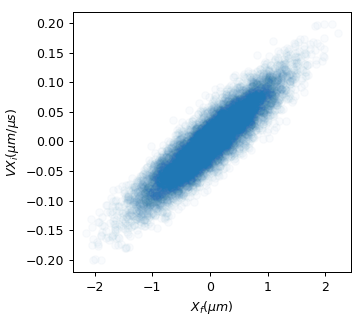

<IPython.core.display.Javascript object>


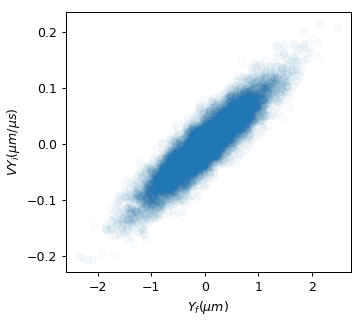

<IPython.core.display.Javascript object>


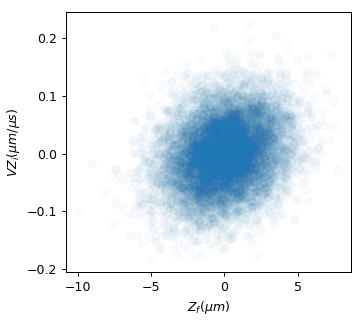

In [98]:
fig,ax=plt.subplots(1,1,figsize=(4.5,4))
ax.scatter(xf,vxi,alpha=0.025)
ax.set_xlabel("$X_f (\mu m)$")
ax.set_ylabel("$VX_i (\mu m/\mu s)$")
fig.tight_layout()
fig.show()

fig,ax=plt.subplots(1,1,figsize=(4.5,4))
ax.scatter(yf,vyi,alpha=0.025)
ax.set_xlabel("$Y_f (\mu m)$")
ax.set_ylabel("$VY_i (\mu m/\mu s)$")
fig.tight_layout()
fig.show()

fig,ax=plt.subplots(1,1,figsize=(4.5,4))
ax.scatter(zf,vzi,alpha=0.025)
ax.set_xlabel("$Z_f (\mu m)$")
ax.set_ylabel("$VZ_i (\mu m/\mu s)$")
fig.tight_layout()
fig.show()

In [134]:
beam_u = lambda w, zr, x, y, z: np.exp(-2*(x**2+y**2+z**2)/w**2/(1+(z/zr)**2))/(1+(z/zr)**2)

Uk = 1/2*mcs*(vxi**2+vyi**2+vzi**2)/kb*1e3
Upi = -Ut(Pt,w0)*beam_u(w0,zr_exp,xi,yi,zi)
Upf = -Ut(Pt,w0)*beam_u(w0,zr_exp,xf,yf,zf)

bad_inds = np.argwhere(Uk+Upi>0)
Ui = Upi+Uk
Ui[bad_inds] = np.NaN
Uf = Upf+Uk
Uf[bad_inds] = np.NaN

keep = Uf<0
ret = sum(keep)/(n-len(bad_inds))
print(ret)

0.9579262877442274


In [122]:
fig,ax=plt.subplots(1,1,figsize=(4.5,4))
ax.scatter(sqrt(xi**2+yi**2+zi**2),Ui,alpha=0.025)
ax.set_xlabel("$|\vec{X}| (\mu m)$")
ax.set_ylabel("$Up_i+Uk (mK)$")
fig.tight_layout()
fig.show()

fig,ax=plt.subplots(1,1,figsize=(4.5,4))
ax.hist(Ui)
ax.set_xlabel("$X_i (\mu m)$")
ax.set_ylabel("$Up_i (J)$")
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


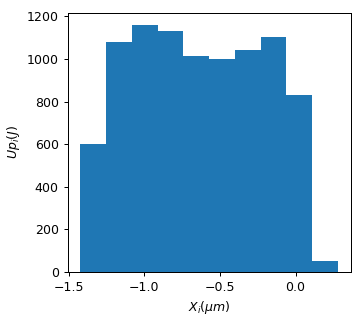

In [123]:
fig,ax=plt.subplots(1,1,figsize=(4.5,4))
ax.scatter(sqrt(xf**2+yf**2+zf**2),Uf,alpha=0.025)
ax.set_xlabel("$|\vec{X}| (\mu m)$")
ax.set_ylabel("$Up_i+Uk (mK)$")
fig.tight_layout()
fig.show()

fig,ax=plt.subplots(1,1,figsize=(4.5,4))
ax.hist(Uf)
ax.set_xlabel("$X_i (\mu m)$")
ax.set_ylabel("$Up_i (J)$")
fig.tight_layout()
fig.show()

In [107]:
Upi

array([-2.18108715e-24, -1.81732021e-23, -7.03092092e-26, ...,
       -1.34783898e-23, -1.14401170e-23, -1.44595958e-23])